# Developing and testing an ARMA(1,1) Noise Model for Pastas
*R.A. Collenteur, University of Graz, May 2020*

In this notebook an Autoregressive-Moving-Average (ARMA(1,1)) noise model is developed for Pastas models. This new noise model is tested against synthetic data generated with Statsmodels' ARMA model. The model is tested on head time series with a regular time step.

**Warning:** It should be noted that the timestep may be non-equidistant in this formulation, but this model is not yet tested for irregular time steps. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammainc, gammaincinv
import statsmodels.api as stats

import pastas as ps
from numba import njit

import pastas as ps
ps.set_log_level("ERROR")
ps.show_versions(numba=True)

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]
Numpy version: 1.17.5
Scipy version: 1.4.1
Pandas version: 1.0.3
Pastas version: 0.15.0b
numba version:  0.48.0


## 1. Develop the AMRA(1,1) Noise Model for Pastas

The following formula is used to calculate the noise according to the ARMA(1,1) process:

$$ \upsilon_t = r_t - r_{t-1}  e^{-\Delta t/\alpha} - \upsilon_{t-1} e^{-\Delta t/\theta}$$

where $\upsilon$ is the noise, $\Delta t$ the time step between the residuals ($r$), and respectively $\alpha$ [days] and $\theta$ [days] the parameters of the AR and MA parts of the model. The model is named `ArmaModel` and can be found in `noisemodel.py`. It is added to a Pastas model as follows: `ml.add_noisemodel(ps.ArmaModel())`

## 2. Generate synthetic head time series

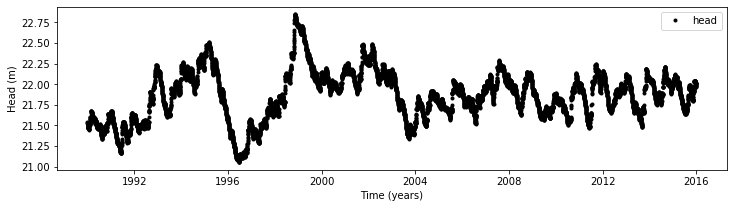

In [2]:
# Define the response function
def gamma_tmax(A, n, a, cutoff=0.999):
    return gammaincinv(n, cutoff) * a

def gamma_step(A, n, a, cutoff=0.999):
    tmax = gamma_tmax(A, n, a, cutoff)
    t = np.arange(0, tmax, 1)
    s = A * gammainc(n, t / a)
    return s

def gamma_block(A, n, a, cutoff=0.999):
    # returns the gamma block response starting at t=0 with intervals of delt = 1
    s = gamma_step(A, n, a, cutoff)
    return np.append(s[0], s[1:] - s[:-1])

# Read in some data
rain = ps.read.read_knmi('../data/etmgeg_260.txt', variables='RH').series
evap = ps.read.read_knmi('../data/etmgeg_260.txt', variables='EV24').series

# Set the True parameters
Atrue = 800
ntrue = 1.1
atrue = 200
dtrue = 20

# Generate the head
step = gamma_block(Atrue, ntrue, atrue)[1:]
lenstep = len(step)
h = dtrue * np.ones(len(rain) + lenstep)
for i in range(len(rain)):
    h[i:i + lenstep] += rain[i] * step
head = pd.DataFrame(index=rain.index, data=h[:len(rain)],)
head = head['1990':'2015']

# Plot the head without noise
plt.figure(figsize=(12,3))
plt.plot(head,'k.', label='head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Time (years)');

## 3. Generate ARMA(1,1) noise and add it to the synthetic heads
In the following code-block, noise is generated using an ARMA(1,1) process from Statsmodels. This procedure was suggested by Eit van der Meulen. More information about the ARMA model can be found on the [statsmodels website](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html). The noise is added to the head series generated in the previous code-block.

In [3]:
# reproduction of random numbers
np.random.seed(1234)
alpha= -0.8
ar = np.array([1, alpha])
theta = 0.7
ma = np.r_[1, theta]
arma = stats.tsa.ArmaProcess(ar, ma)

# generate sameples
noise = arma.generate_sample(head[0].index.size)

head_noise = head[0] + noise * 0.05

## 4. Create and solve a Pastas Model

Model Results 0                    Fit Statistics
nfev     14                     EVP         82.69
nobs     8946                   R2           0.83
noise    True                   RMSE         0.14
tmin     1991-01-01 00:00:00    AIC          5.80
tmax     2015-06-29 00:00:00    BIC         48.39
freq     D                      Obj         11.12
warmup   3650 days 00:00:00     ___              
solver   LeastSquares           ___              

Parameters (6 were optimized)
                optimal  stderr     initial  vary
recharge_A   806.269216  ±1.99%  217.313623  True
recharge_n     1.085838  ±0.83%    1.000000  True
recharge_a   212.164571  ±3.40%   10.000000  True
constant_d    19.992352  ±0.19%   21.869284  True
noise_alpha    4.603049  ±3.62%    1.000000  True
noise_theta    2.725392  ±3.03%    0.500000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.59
           constant_d -0.99
recharge_n recharge_a -0.66
recharge_a constant_d -0.57


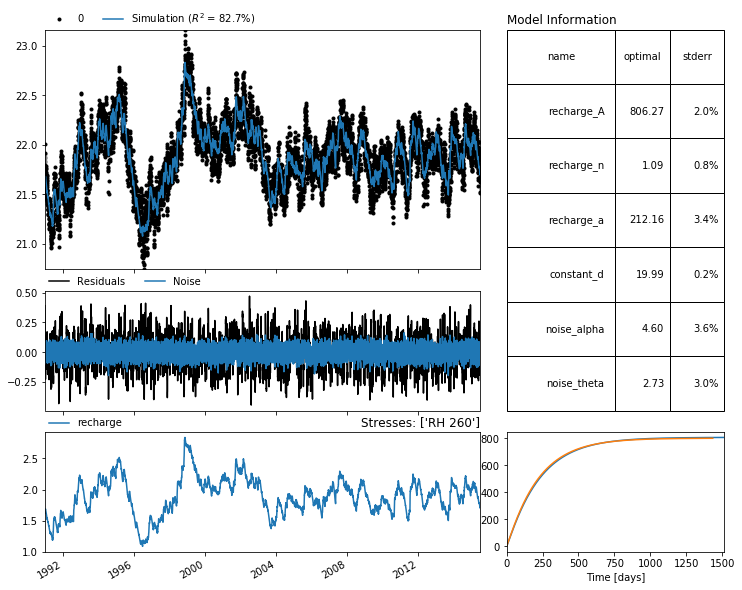

In [4]:
ml = ps.Model(head_noise)
sm = ps.StressModel(rain, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArmaModel())

ml.solve(tmin="1991", tmax='2015-06-29', noise=True)
axes = ml.plots.results();
axes[-1].plot(gamma_step(Atrue, ntrue, atrue))

## 5. Did we find back the original ARMA parameters?

In [5]:
print(np.exp(-1./ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", -alpha)
print(np.exp(-1./ml.parameters.loc["noise_theta", "optimal"]).round(2), "vs.", theta)

0.8 vs 0.8
0.69 vs. 0.7


## 6. So is the autocorrelation removed correctly?

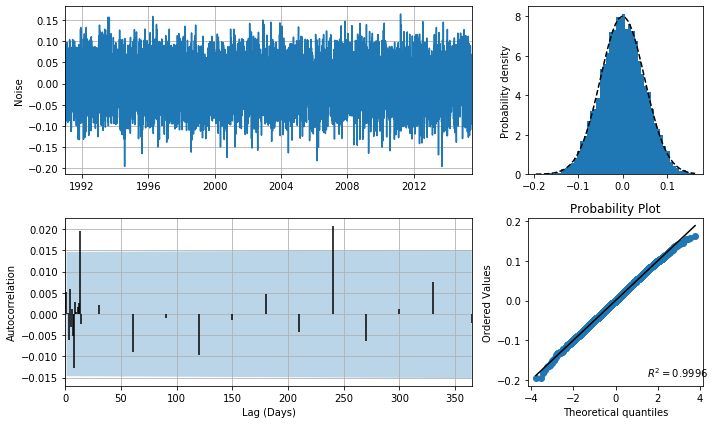

In [6]:
ml.plots.diagnostics();

That seems okay. It is important to understand that this noisemodel will only help in removing autocorrelations at the first time lag, but not at larger time lags, compared to its AR(1) counterpart. 

## 7. What happens if we use an AR(1) model?

Model Results 0                    Fit Statistics
nfev     15                     EVP         82.68
nobs     8946                   R2           0.83
noise    True                   RMSE         0.14
tmin     1991-01-01 00:00:00    AIC          3.09
tmax     2015-06-29 00:00:00    BIC         38.58
freq     D                      Obj         15.83
warmup   3650 days 00:00:00     ___              
solver   LeastSquares           ___              

Parameters (5 were optimized)
                optimal  stderr     initial  vary
recharge_A   806.893090  ±2.68%  217.313623  True
recharge_n     1.088887  ±1.28%    1.000000  True
recharge_a   211.913125  ±4.68%   10.000000  True
constant_d    19.990605  ±0.25%   21.869284  True
noise_alpha    9.278932  ±4.66%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.59
           constant_d -0.99
recharge_n recharge_a -0.69
recharge_a constant_d -0.57
0.9 vs 0.8


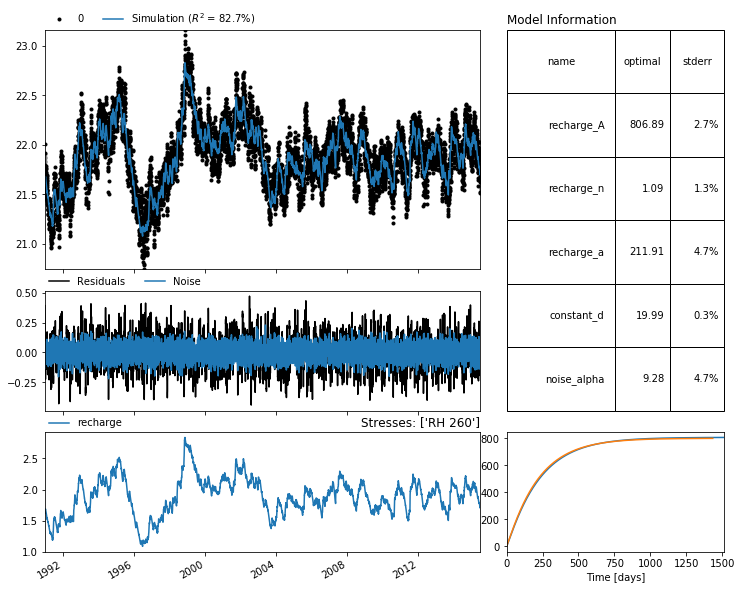

In [7]:
ml = ps.Model(head_noise)
sm = ps.StressModel(rain, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm)

ml.solve(tmin="1991", tmax='2015-06-29', noise=True)
axes = ml.plots.results();
axes[-1].plot(gamma_step(Atrue, ntrue, atrue))

print(np.exp(-1./ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", -alpha)

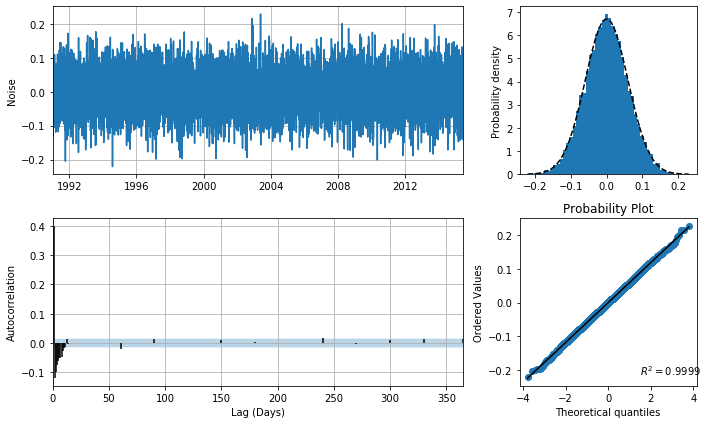

In [8]:
ml.plots.diagnostics();

Significant autocorrelation is still present at lag 1 and the parameter of the AR(1) is overestimated, trying to correct for the lack of an MA(1) part. This is to be expected, as the MA(1) process generates autocorrelation at this first time lag. A possible effect of failing to remove the autocorrelation at lag 1 may be that the parameter standard errors are under- or overestimated. Although that does not seem the case for this synthetic, real life exampels may suffer from this.